# Time Series EDA

- single continuous variable over (uniformly distributed) time
- identify trend and seasonality

## Setup

°F = (K - 273.15) x 1.8000 + 32.00

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [3]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

In [5]:
df = pd.read_csv('sa_temps.csv', index_col='datetime', parse_dates=True).sort_index()
df.temp = (df.temp - 273.15) * 1.8 + 32

print('Date Range:', df.index.min(), 'to', df.index.max())
print('Shape:', df.shape)

df.head(10)

Date Range: 2012-10-01 13:00:00 to 2017-11-30 00:00:00
Shape: (45252, 1)


,temp
datetime,
2012-10-01 13:00:00,61.052000
2012-10-01 14:00:00,61.076568
2012-10-01 15:00:00,61.139294
2012-10-01 16:00:00,61.202020
2012-10-01 17:00:00,61.264747
2012-10-01 18:00:00,61.327473
2012-10-01 19:00:00,61.390200
2012-10-01 20:00:00,61.452926
2012-10-01 21:00:00,61.515652


- **seasonality**: a repeated cycle in the data. Occurs at a fixed frequency. In our weather data there is yearly and daily seasonality
- **trend**: long term upwards or downwards movement
- **cycle**: Some arbitrary chunk of time, usually longer than a season, or consists of multiple seasons

## Data Splitting

- Ideally all splits contain a season
- Human-based
- Percentage based
- Cross Validation

### Percentage-Based

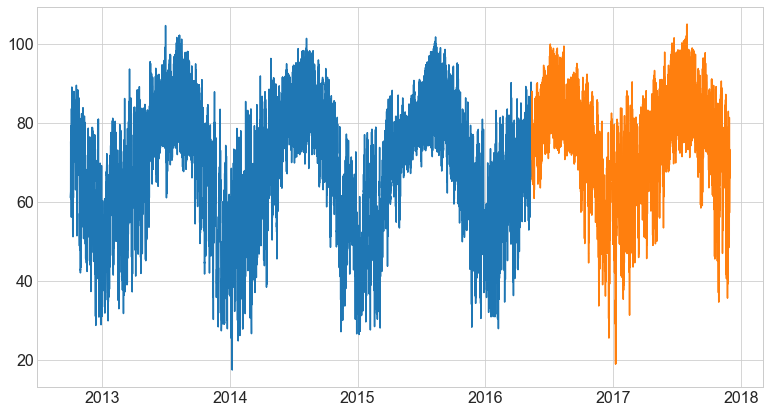

In [6]:
train_size = .70
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index] # everything up (not including) to the test_start_index
test = df[test_start_index:] # everything from the test_start_index to the end

plt.plot(train.index, train.temp)
plt.plot(test.index, test.temp)

### Human-Based

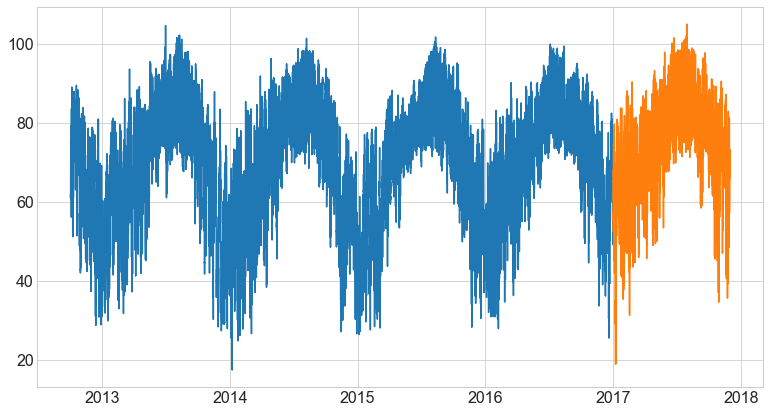

In [7]:
train = df[:'2016'] # includes 2016
test = df['2017']

plt.plot(train.index, train.temp)
plt.plot(test.index, test.temp)

In [8]:
train

,temp
datetime,
2012-10-01 13:00:00,61.052000
2012-10-01 14:00:00,61.076568
2012-10-01 15:00:00,61.139294
2012-10-01 16:00:00,61.202020
2012-10-01 17:00:00,61.264747
...,...
2016-12-31 19:00:00,63.230000
2016-12-31 20:00:00,68.216000
2016-12-31 21:00:00,70.664000


## Visualizations

In [10]:
y = train.temp
y.head()

datetime
2012-10-01 13:00:00    61.052000
2012-10-01 14:00:00    61.076568
2012-10-01 15:00:00    61.139294
2012-10-01 16:00:00    61.202020
2012-10-01 17:00:00    61.264747
Name: temp, dtype: float64

### Don't consider the time series

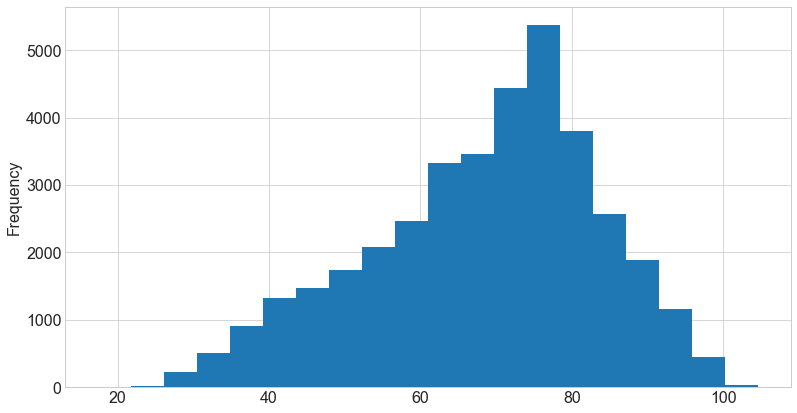

In [12]:
y.plot.hist(bins=20)

- by month
- by weekday

<ipython-input-18-075469ac812b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['month'] = train.index.month


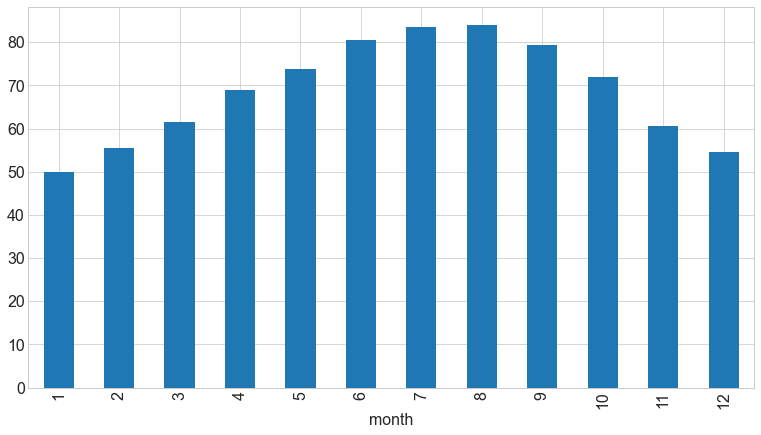

In [18]:
train['month'] = train.index.month

train.groupby('month').temp.mean().plot.bar()

In [21]:
pd.__version__

'1.1.3'

if you have > 1.0 -- use `.day_name()`

if < 1.0 use `weekday_name`

In [22]:
train['weekday'] = train.index.day_name()
train.head()

<ipython-input-22-d3d3342929dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['weekday'] = train.index.day_name()


,temp,month,weekday
datetime,,,
2012-10-01 13:00:00,61.052000,10,Monday
2012-10-01 14:00:00,61.076568,10,Monday
2012-10-01 15:00:00,61.139294,10,Monday
2012-10-01 16:00:00,61.202020,10,Monday
2012-10-01 17:00:00,61.264747,10,Monday


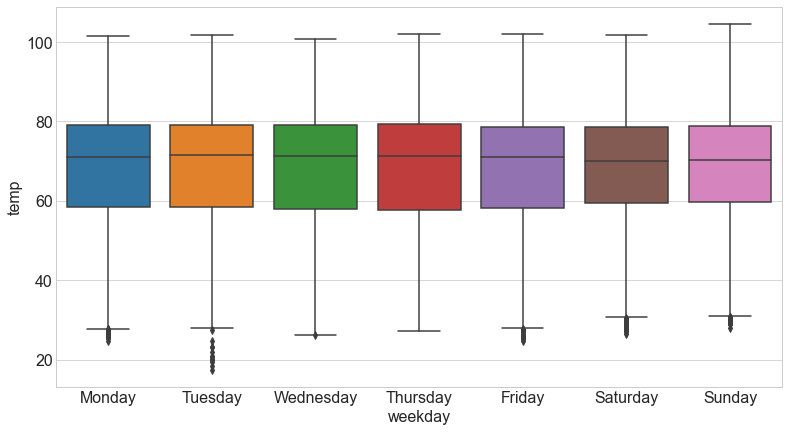

In [23]:
sns.boxplot(data=train, y='temp', x='weekday')

### Visualize the target over time

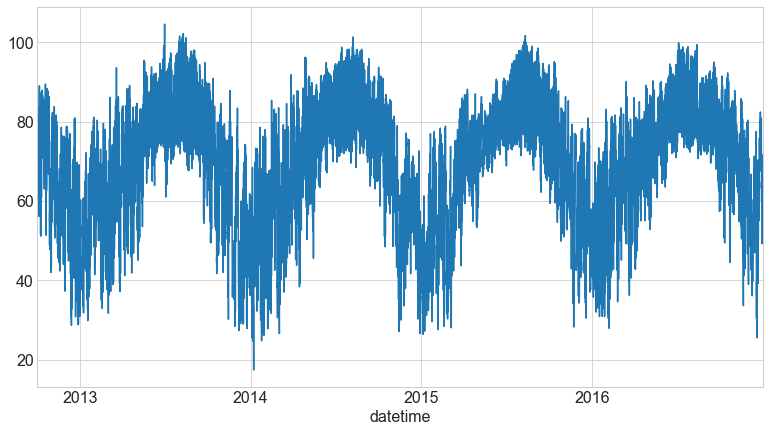

In [24]:
y.plot()

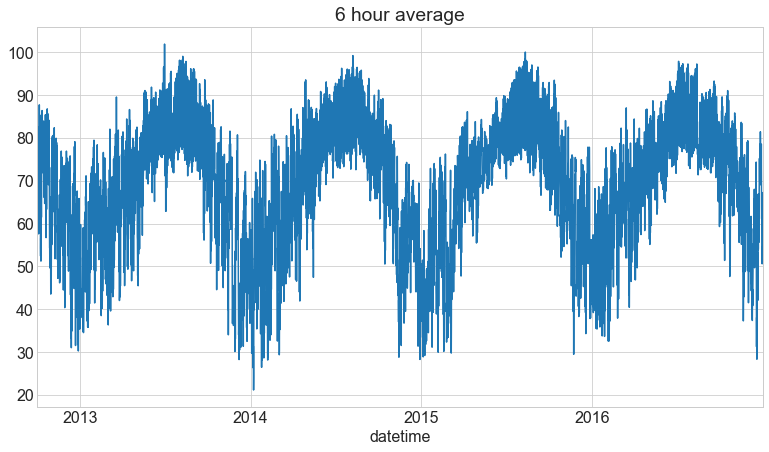

In [25]:
y.resample('6H').mean().plot(title='6 hour average')

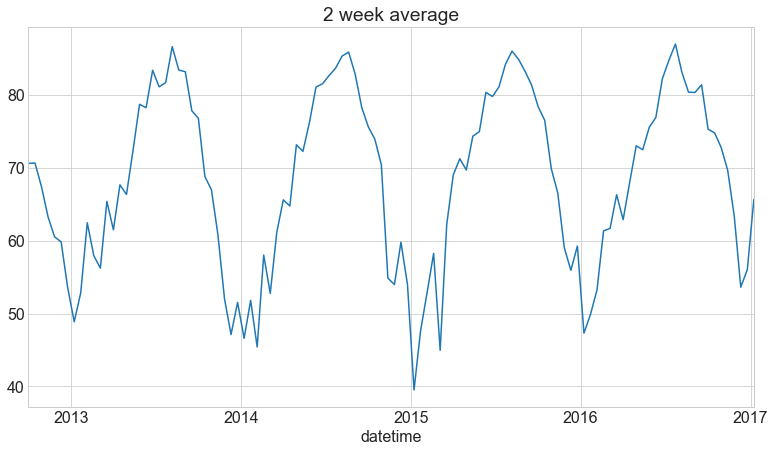

In [27]:
y.resample('2W').mean().plot(title='2 week average')

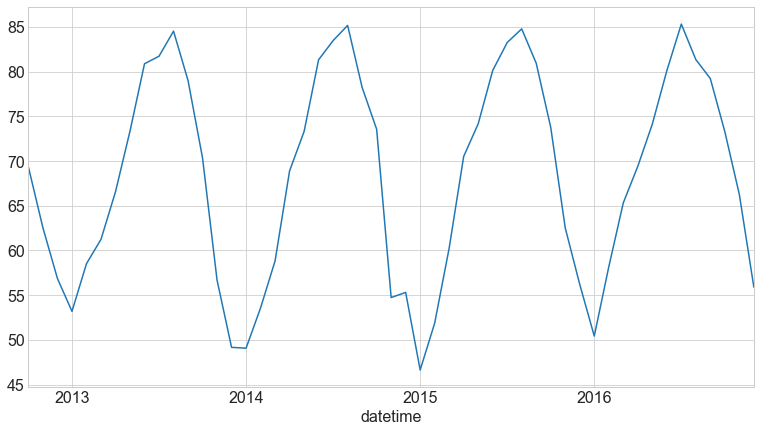

In [29]:
y.resample('M').mean().plot()

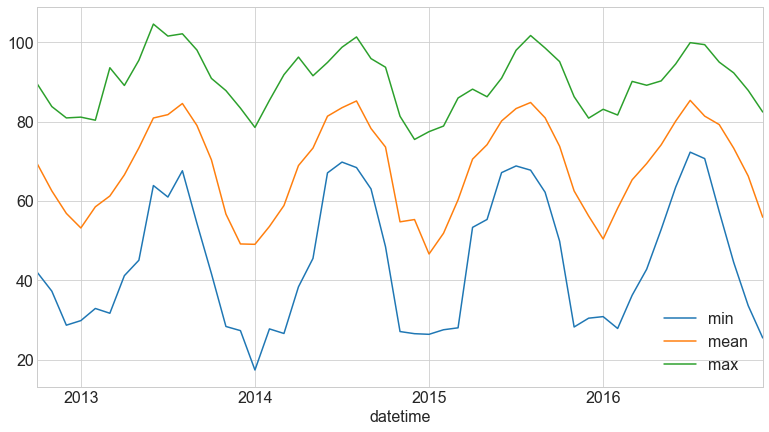

In [31]:
y.resample('M').agg(['min', 'mean', 'max']).plot()

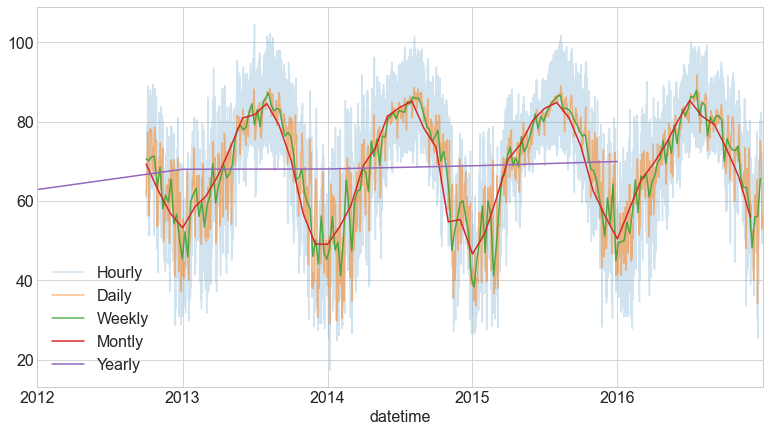

In [32]:
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().plot(alpha=.5, label='Daily')
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()

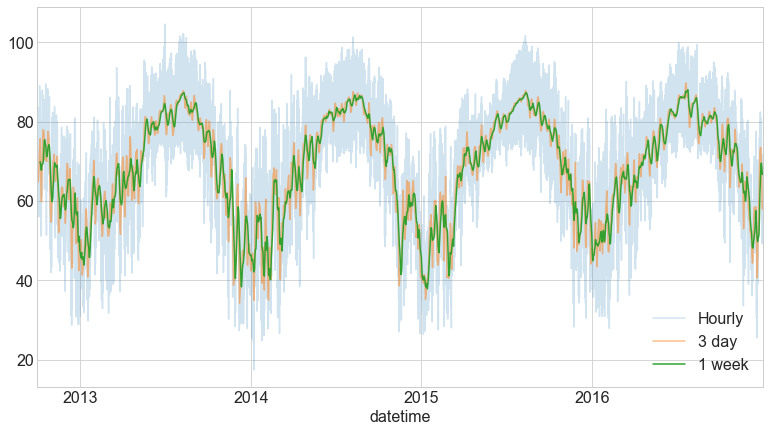

In [33]:
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().rolling(3).mean().plot(alpha=.5, label='3 day')
y.resample('D').mean().rolling(7).mean().plot(alpha=8, label='1 week')
plt.legend()

### Visualize change over time

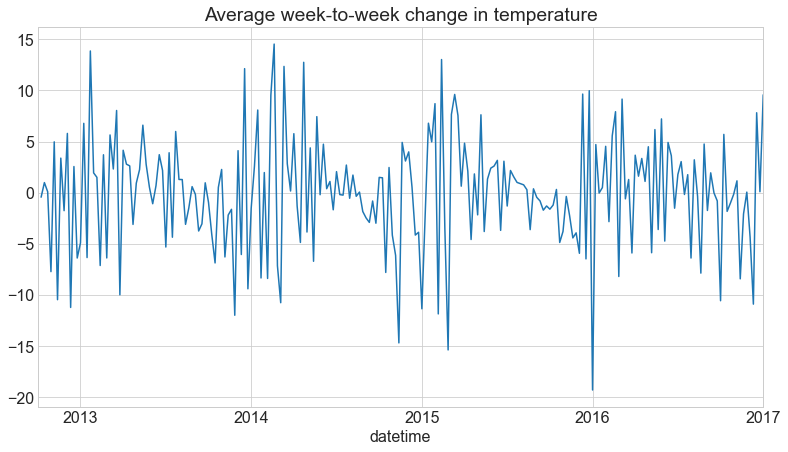

In [34]:
y.resample('W').mean().diff().plot(title='Average week-to-week change in temperature')

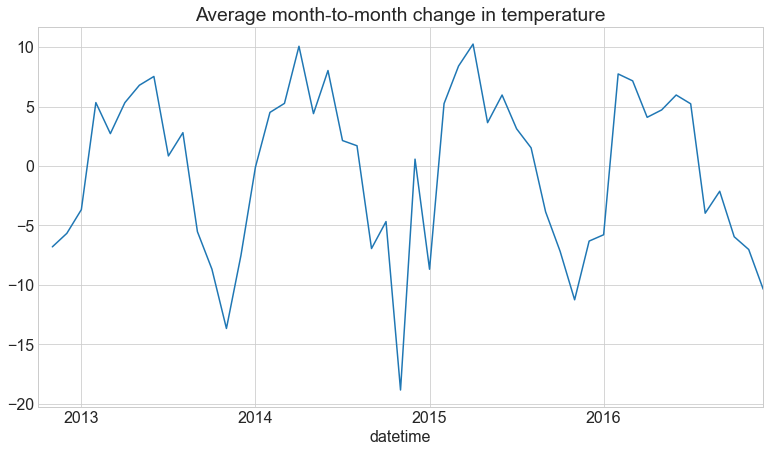

In [35]:
y.resample('M').mean().diff().plot(title='Average month-to-month change in temperature')

### Seasonal Plot

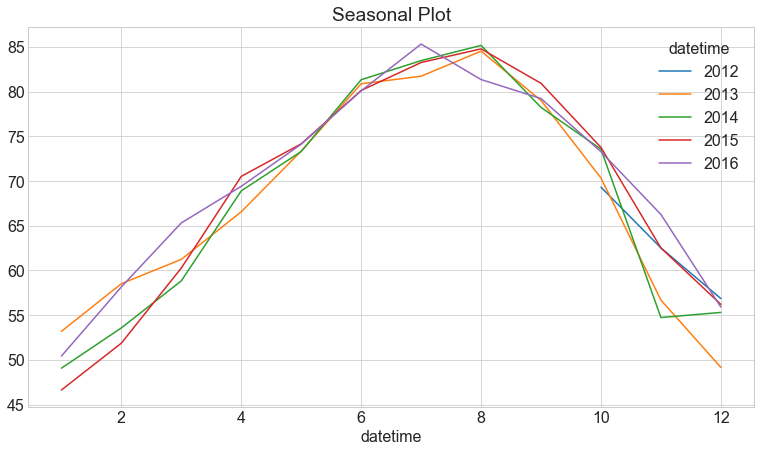

In [36]:
# .unstack turns an index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot')

### Seasonal Subseries Plot

In [50]:
y.groupby([y.index.year, y.index.month]).mean().unstack()

datetime,1,2,3,4,5,6,7,8,9,10,11,12
datetime,,,,,,,,,,,,
2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.318705,62.521575,56.860014
2013,53.192333,58.522799,61.244479,66.569717,73.358529,80.885728,81.731819,84.534117,79.016805,70.343832,56.686028,49.165310
2014,49.072897,53.579080,58.842459,68.908933,73.311970,81.337658,83.476876,85.178102,78.238621,73.567252,54.735951,55.311824
2015,46.631940,51.874683,60.277705,70.526879,74.169747,80.135967,83.264325,84.789859,80.938208,73.766466,62.519181,56.207118
2016,50.427347,58.165749,65.323011,69.415316,74.129780,80.097570,85.325640,81.357023,79.233476,73.284788,66.265047,55.903224


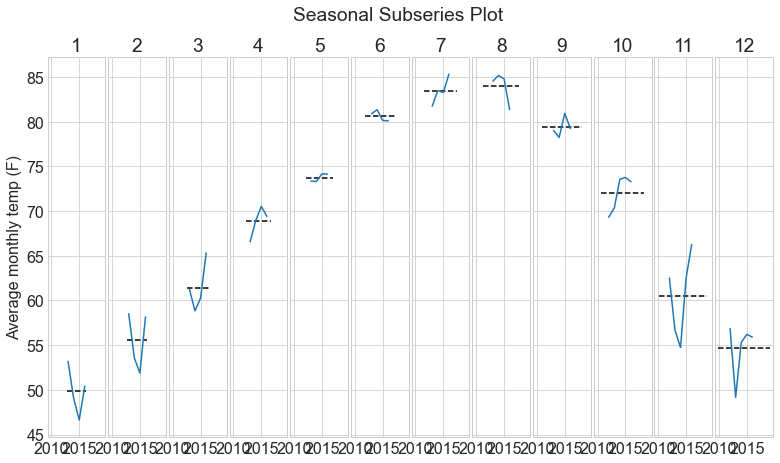

In [44]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim(), ls='--')
    ax.set(xlabel='')

axs[0].set(ylabel='Average monthly temp (F)')
fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=.05)
# fig.tight_layout()

### Lag Plot

Text(0.5, 1.0, 'Lag plot with lag=1')

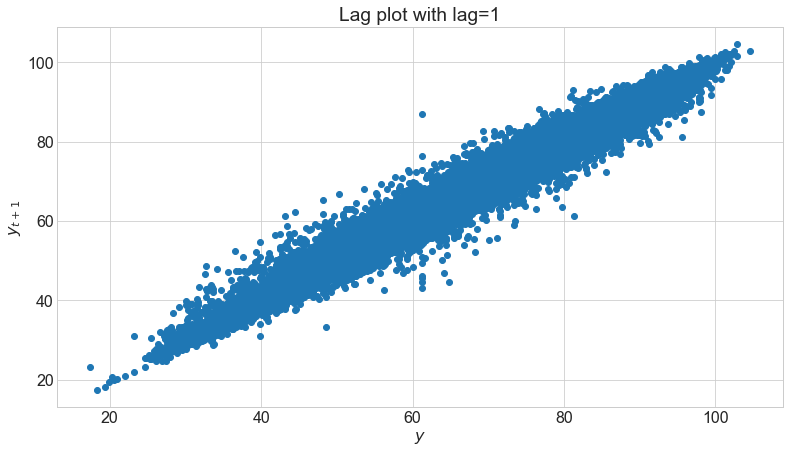

In [51]:
plt.scatter(y, y.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')

<ipython-input-52-e93540a5c422>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['y(t + 1)'] = train.temp.shift(-1)


[Text(0, 0.5, 't + 1'), Text(0.5, 0, 't')]

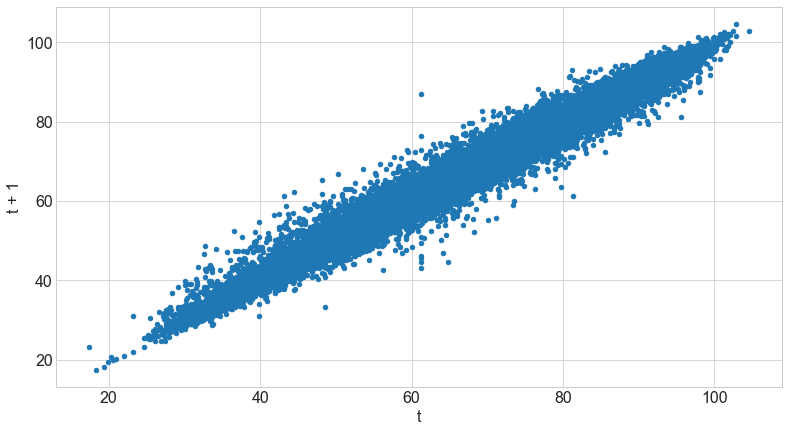

In [52]:
train['y(t + 1)'] = train.temp.shift(-1)
ax = train.plot.scatter(x='temp', y='y(t + 1)')
ax.set(xlabel='t', ylabel='t + 1')

In [ ]:
del train['y(t + 1)']

In [55]:
del train['month']

,this_week,the_next_week
datetime,,
2012-10-07,70.595201,70.152821
2012-10-14,70.152821,71.138375
2012-10-21,71.138375,71.230464
2012-10-28,71.230464,63.510554
2012-11-04,63.510554,68.482625
...,...,...
2016-12-04,59.062094,48.163625
2016-12-11,48.163625,55.979132
2016-12-18,55.979132,56.073143


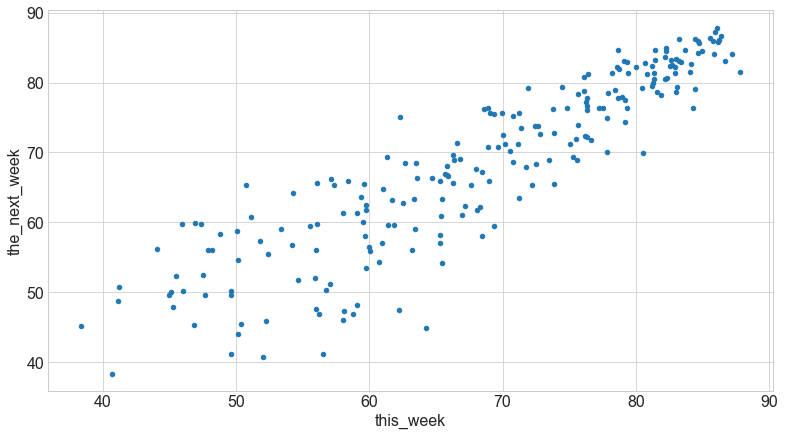

In [57]:
weekly = train.resample('W').mean()
weekly['the_next_week'] = weekly.temp.shift(-1)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='the_next_week')
weekly

,this_week,12_weeks_out
datetime,,
2012-10-07,70.595201,50.376741
2012-10-14,70.152821,45.473616
2012-10-21,71.138375,52.252877
2012-10-28,71.230464,45.907936
2012-11-04,63.510554,59.763739
...,...,...
2016-12-04,59.062094,NaN
2016-12-11,48.163625,NaN
2016-12-18,55.979132,NaN


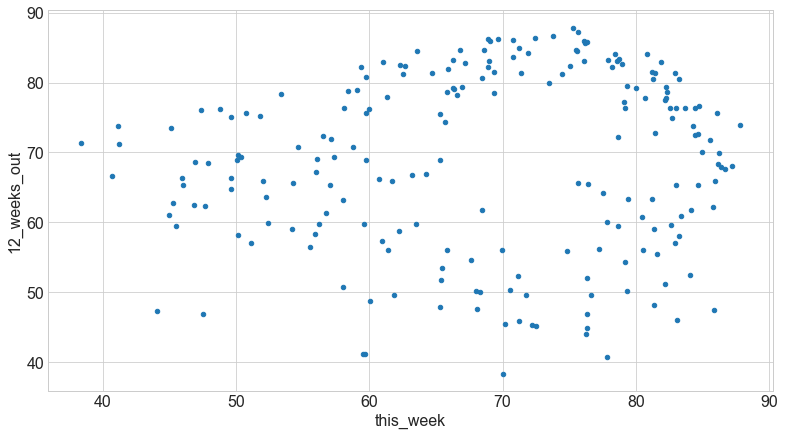

In [58]:
weekly = train.resample('W').mean()
weekly['12_weeks_out'] = weekly.temp.shift(-12)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='12_weeks_out')
weekly

,this_week,half_a_year_later
datetime,,
2012-10-07,70.595201,63.558611
2012-10-14,70.152821,66.345532
2012-10-21,71.138375,68.965502
2012-10-28,71.230464,65.862071
2012-11-04,63.510554,66.797107
...,...,...
2016-12-04,59.062094,NaN
2016-12-11,48.163625,NaN
2016-12-18,55.979132,NaN


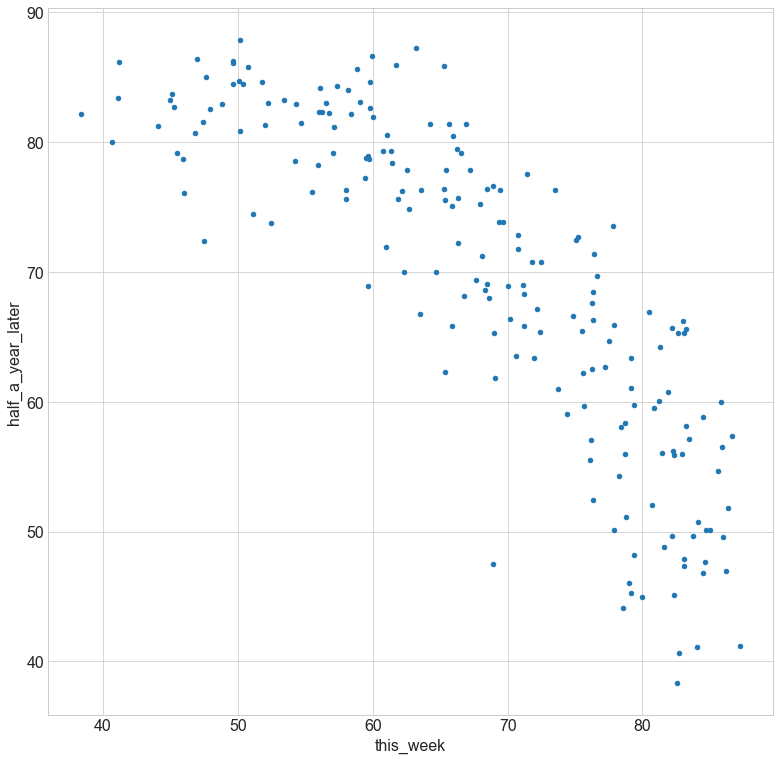

In [59]:
weekly = train.resample('W').mean()
weekly['half_a_year_later'] = weekly.temp.shift(-26)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='half_a_year_later', figsize=(13, 13))
weekly

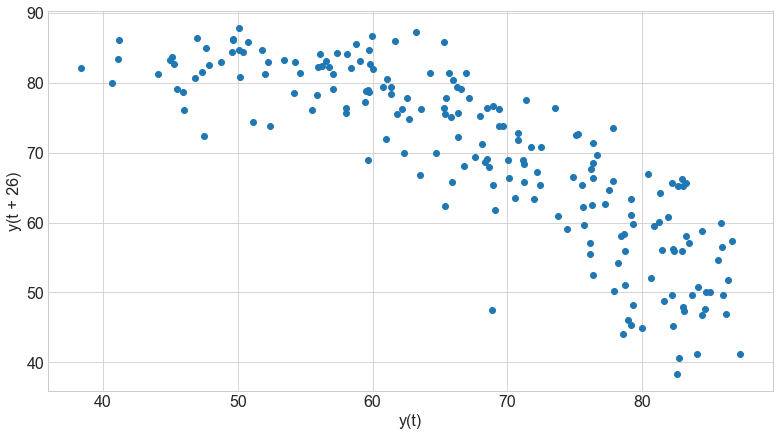

In [60]:
pd.plotting.lag_plot(train.temp.resample('W').mean(), lag=26)

### Autocorrelation Plot

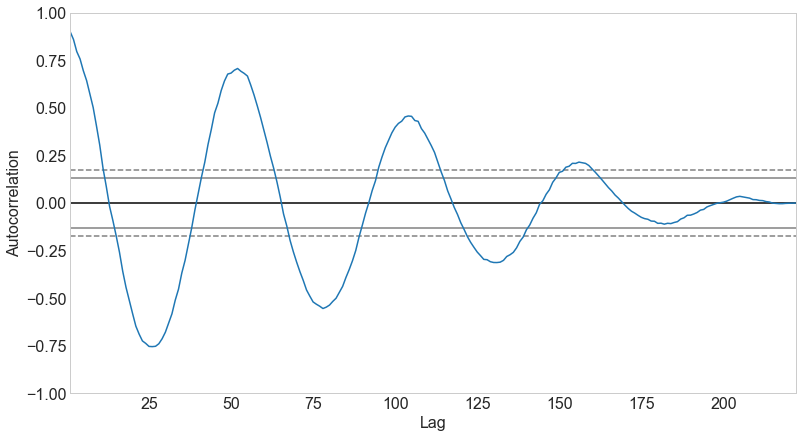

In [61]:
pd.plotting.autocorrelation_plot(train.temp.resample('W').mean())

### Seasonal Decomposition

$$ y = S + T + \epsilon $$

seasonal + trend + error

In [62]:
y = train.temp.resample('W').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

,y,trend,seasonal,resid
datetime,,,,
2012-10-07,70.595201,NaN,8.545501,NaN
2012-10-14,70.152821,NaN,7.255470,NaN
2012-10-21,71.138375,NaN,2.468309,NaN
2012-10-28,71.230464,NaN,1.820126,NaN
2012-11-04,63.510554,NaN,-0.114287,NaN


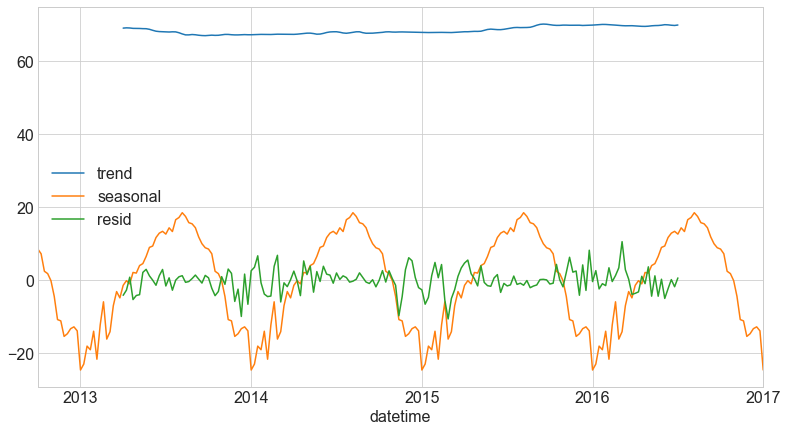

In [63]:
decomposition.iloc[:, 1:].plot()

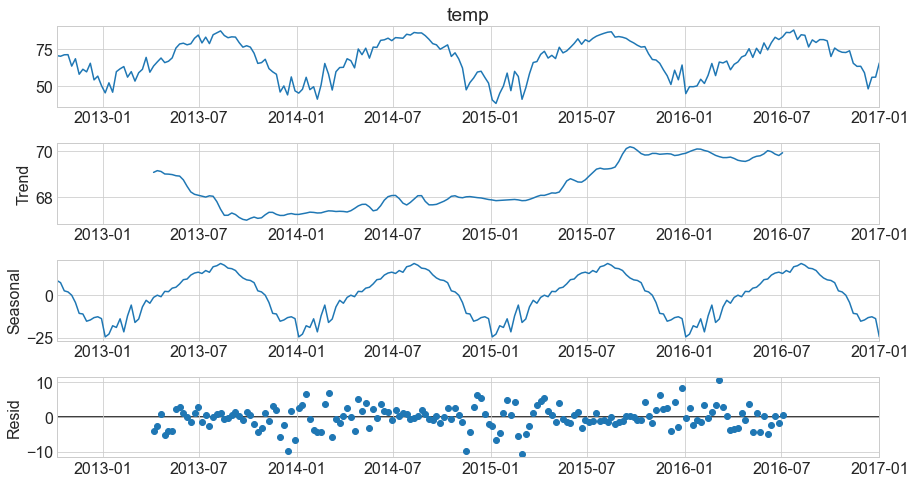

In [64]:
# the value returned from seasonal_decompose can itself be plotted:
result.plot()
None

### Seasonal Decomposition with Fake Data

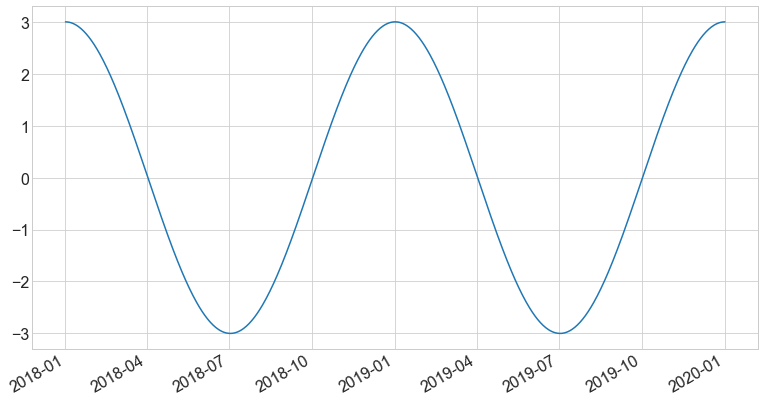

In [71]:
idx = pd.date_range('2018', '2020', 365 * 2)
S = 3 * np.cos(np.linspace(0, 4 * np.pi, 365 * 2))
S = pd.Series(S, index=idx)
S.plot()

(-3.0, 3.0)

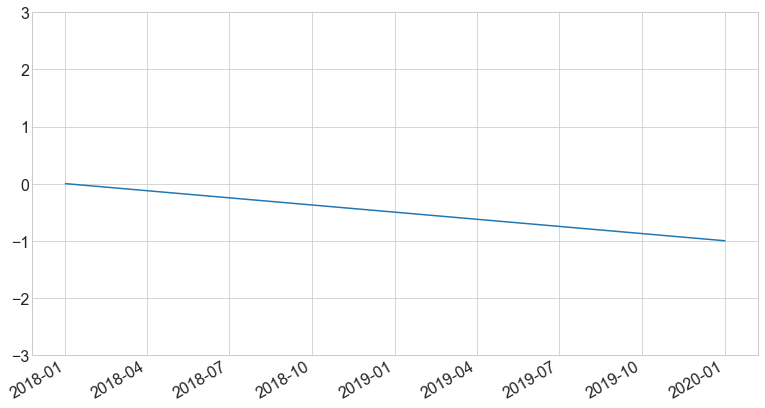

In [74]:
T = np.linspace(0, -1, 365 * 2)
T = pd.Series(T, index=idx)
T.plot()
plt.ylim(-3, 3)

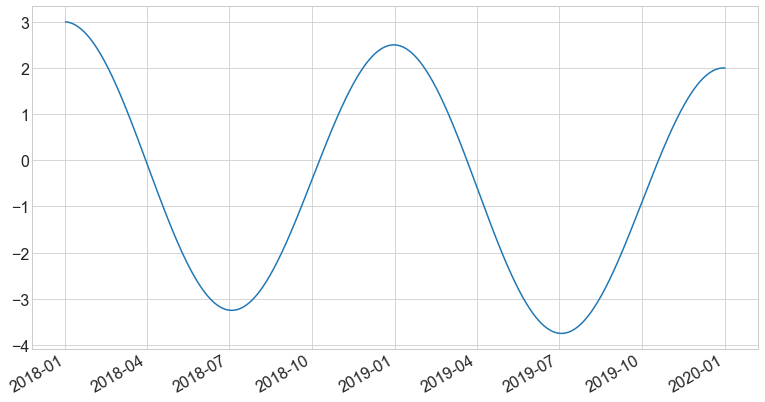

In [75]:
(S + T).plot()

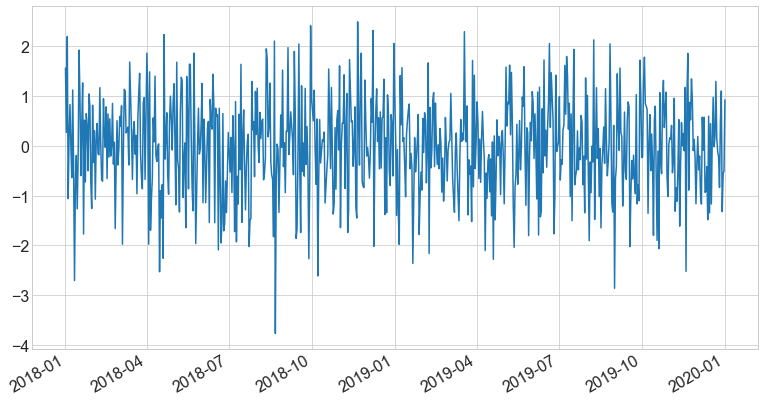

In [77]:
E = np.random.randn(365 * 2)
E = pd.Series(E, index=idx)
E.plot()

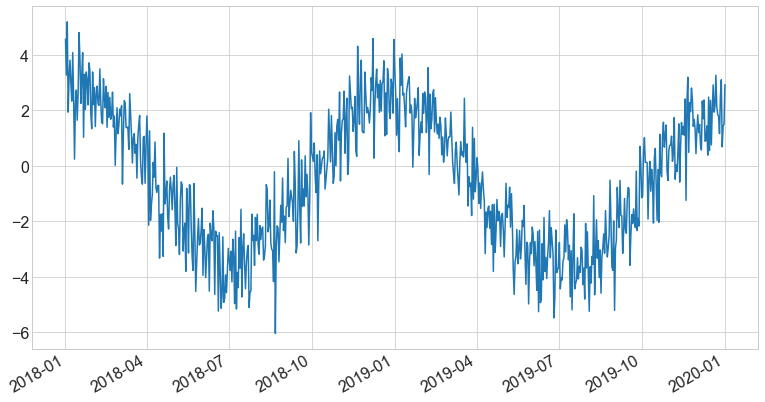

In [78]:
(S + T + E).plot()

### Categories over time

In [79]:
train = train.resample('D').mean()
# create a categorical feature
train['temp_bin'] = pd.qcut(train.temp, 4, labels=['cold', 'cool', 'warm', 'hot'])
train.groupby('temp_bin').mean()

,temp
temp_bin,
cold,49.381699
cool,65.200219
warm,75.447977
hot,83.449087


In [80]:
train.sample(12)

,temp,temp_bin
datetime,,
2016-12-11,52.262000,cold
2015-10-03,72.546679,warm
2015-05-04,74.968213,warm
2015-08-30,81.722810,hot
2013-03-17,67.905313,cool
2014-02-02,53.368250,cold
2014-12-06,62.179138,cool
2016-05-02,66.294500,cool
2012-10-01,61.330942,cool


How can we visualize the `temp_bin` feature over time?

Text(0, 0.5, '% of days in the month')

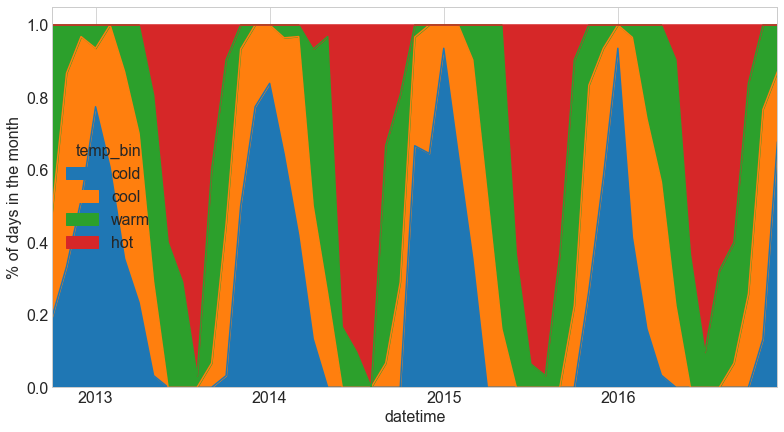

In [102]:
(train.groupby('temp_bin')
 .resample('M')
 .size() # like COUNT(*)
 .unstack(0) # turns an index level into columns
 .fillna(0)
 .astype(int)
 .apply(lambda row: row / row.sum(), axis=1) # raw nums to % of the row
 .plot.area()
)
plt.ylabel('% of days in the month')

Text(0, 0.5, '% of days in the month')

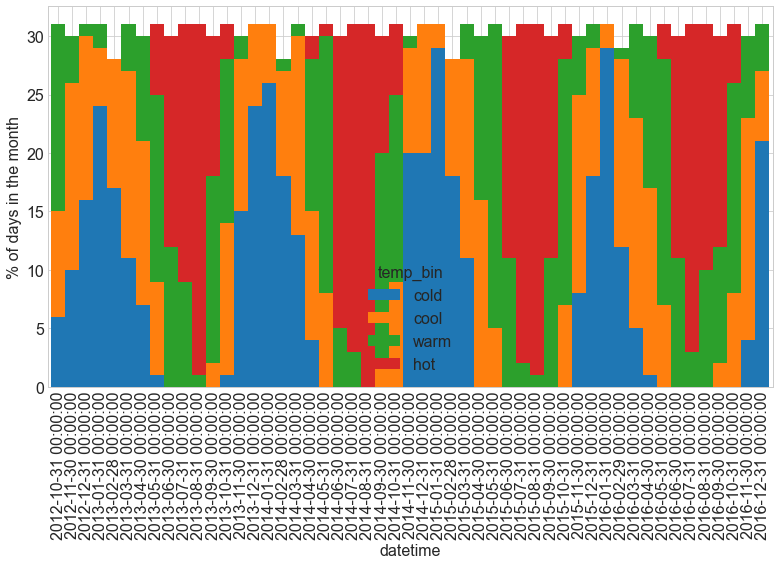

In [99]:
(train.groupby('temp_bin')
 .resample('M')
 .size()
 .unstack(0)
 .fillna(0)
 .astype(int)
 .plot.bar(stacked=True, width=1)
)
plt.ylabel('% of days in the month')

[Text(0, 0, 'January'),
 Text(0, 0, 'February'),
 Text(0, 0, 'March'),
 Text(0, 0, 'April'),
 Text(0, 0, 'May'),
 Text(0, 0, 'June'),
 Text(0, 0, 'July'),
 Text(0, 0, 'August'),
 Text(0, 0, 'September'),
 Text(0, 0, 'October'),
 Text(0, 0, 'November'),
 Text(0, 0, 'December'),
 Text(0, 0, 'January'),
 Text(0, 0, 'February'),
 Text(0, 0, 'March'),
 Text(0, 0, 'April'),
 Text(0, 0, 'May'),
 Text(0, 0, 'June'),
 Text(0, 0, 'July'),
 Text(0, 0, 'August'),
 Text(0, 0, 'September'),
 Text(0, 0, 'October'),
 Text(0, 0, 'November'),
 Text(0, 0, 'December')]

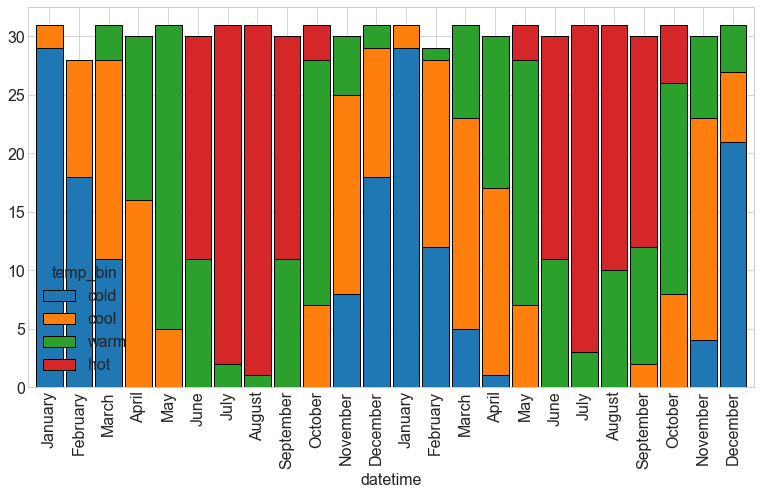

In [117]:
ax = (train['2015':'2016']
 .groupby('temp_bin')
 .resample('M')
 .size()
 .unstack(0)
 .plot.bar(stacked=True, width=.9, ec='black')
)
# take the existing labels, convert them to Timestamps, and then reformat with .strftime
labels = [pd.to_datetime(t.get_text()).strftime('%B') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels)

## `strftime`

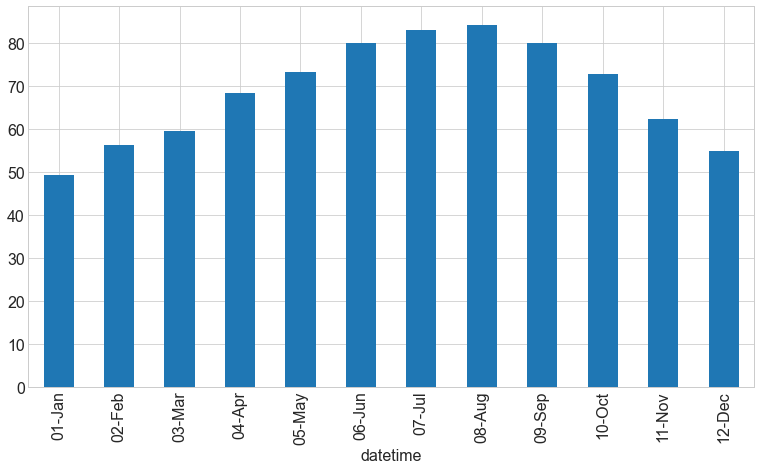

In [120]:
ax = y.groupby(y.index.strftime('%m-%b')).mean().plot.bar()

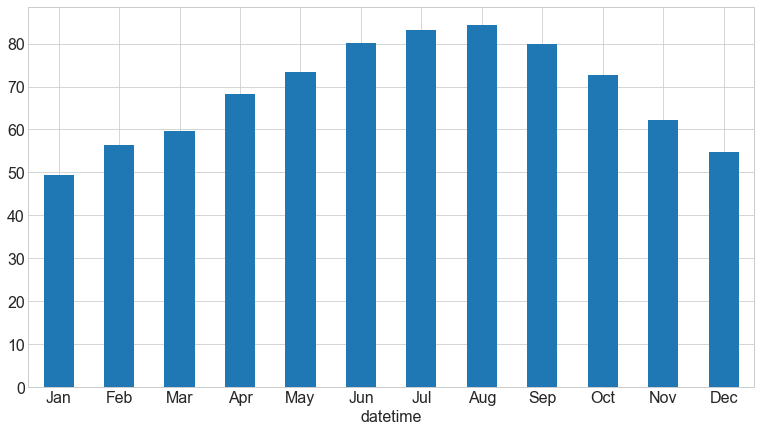

In [123]:
ax = y.groupby(y.index.strftime('%m-%b')).mean().plot.bar()
ax.set_xticklabels([t.get_text()[3:] for t in ax.get_xticklabels()], rotation=0)
None

## Matplotlib Dates

This will only work with `plt.plot` or `ax.plot`, not with the pandas plotting!

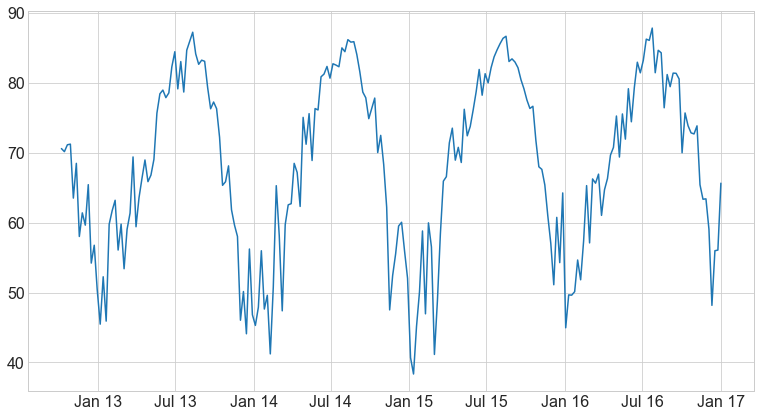

In [124]:
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()

weekly = y.resample('W').mean()

ax.plot(weekly.index, weekly)

ax.xaxis.set_major_formatter(DateFormatter('%b %y'))

## Extras

- Lag plot hue by month
- Distribution of temp bin by month for all years

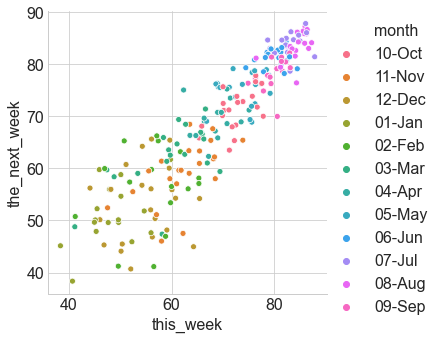

In [131]:
weekly = train.resample('W').mean()
weekly['the_next_week'] = weekly.temp.shift(-1)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly['month'] = weekly.index.strftime('%m-%b')
sns.relplot(data=weekly, y='the_next_week', x='this_week', hue='month')
# weekly.plot.scatter(x='this_week', y='the_next_week')

[Text(0, 0.5, '% of days in the month'),
 Text(0.5, 1.0, 'Distribution of temp_bin overall years')]

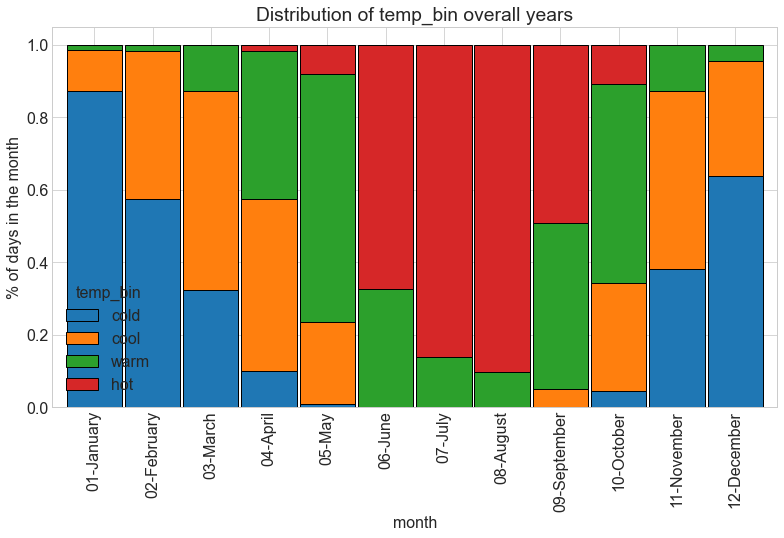

In [141]:
train['month'] = train.index.strftime('%m-%B')
ax = (train.groupby(['month', 'temp_bin'])
 .size()
 .unstack(-1)
 .apply(lambda row: row / row.sum(), axis=1)
 .plot.bar(stacked=True, width=.95, ec='black')
)
ax.set(
    title='Distribution of temp_bin overall years',
    ylabel='% of days in the month',
)